In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import cv2
import os
from os import listdir
from os.path import isfile, join
from aux import DrawCircles, ScaleImage
from circle import Find_Optimum_Circles, Find_Best_Circle, Deriv, Intensity
from scipy import signal

In [55]:
#get a list of files in the folder with pics
folder_path = os.path.abspath('.')+'/Smpl_Im'
file_names = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
images = []
threshed = []
circs = []
ders = []
ints = []
step = 5
accum_res  = 3 # image resolution/accum resolution, 4 means accum is 1/4th of image
min_between = 4 #Min dist between circles. 
minRadius = 640 #Min radius of a circle. 
maxRadius= 740 #The bigest circle expected
Canny_thr = 1100 #anything above that is an edge automatically in Canny, the lower threshold is half of that.
Accum_thr = 1100 #accumulator threshold for the circle centers at the detection stage

min_R_search = 450
max_R_search = 720

for file in file_names:
    print(f"{file}...", end = "")
    image = cv2.imread(folder_path+'/'+file)
    image = ScaleImage(image)
    images.append(image)
    params = [accum_res, min_between, Canny_thr, Accum_thr, minRadius, maxRadius]
    Circles = Find_Optimum_Circles(params_Hough=params, img = image, min_num  = 10, max_num = 30)
    print(f"{len(Circles)} circs", end = "")
    best_circ = Find_Best_Circle(Circles, image)[0]
    circs.append(best_circ)
    img_gr = cv2.adaptiveThreshold(img[:,:,0],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,81,15)
    img_gr = cv2.bitwise_not(img_gr)
    kernel = np.ones((2, 2), np.uint8)
    eroded = cv2.erode(img_gr , kernel, iterations = 3)

    threshed.append(eroded)
    Der_good = Deriv(image= img_gr, center = best_circ[:2],  min_radius = min_R_search, max_radius = max_R_search, step = step)
    Der_good = np.array(Der_good)
    int_good = [   Intensity(img_gr, best_circ[:2] , i, step)    for i in range(min_R_search, max_R_search, step) ]
    int_good  = np.array(int_good)
    ints.append(int_good)
    ders.append(Der_good)


Neg_edges.jpg...11 circs 
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.02
 0.04 0.05 0.07 0.06 0.04 0.02 0.01 0.   0.01 0.01 0.04 0.09 0.14 0.14
 0.11 0.06 0.03 0.03 0.04 0.07 0.11 0.16 0.22 0.27 0.3  0.32 0.32 0.31
 0.26 0.17 0.1  0.04 0.02 0.03 0.1  0.17 0.22 0.3  0.36 0.39 0.39 0.38
 0.33 0.26 0.16 0.1  0.1  0.07 0.05 0.05 0.03 0.03 0.03 0.13 0.3  0.43
 0.47 0.45 0.4  0.35 0.26 0.18 0.13 0.15 0.26 0.31 0.34 0.35]
Crossed at 604
Neg_ag_artifact.jpg...12 circs 
[0.01 0.   0.01 0.05 0.07 0.05 0.02 0.01 0.01 0.02 0.03 0.03 0.02 0.02
 0.01 0.01 0.01 0.02 0.03 0.06 0.04 0.01 0.   0.   0.   0.02 0.03 0.02
 0.01 0.01 0.   0.   0.   0.   0.01 0.01 0.01 0.01 0.02 0.05 0.12 0.21
 0.28 0.32 0.29 0.24 0.24 0.22 0.12 0.03 0.06 0.15 0.21 0.18 0.15 0.13
 0.18 0.19 0.15 0.08 0.05 0.05 0.06 0.08 0.07 0.06 0.1  0.15 0.24 0.34
 0.38 0.32 0.24 0

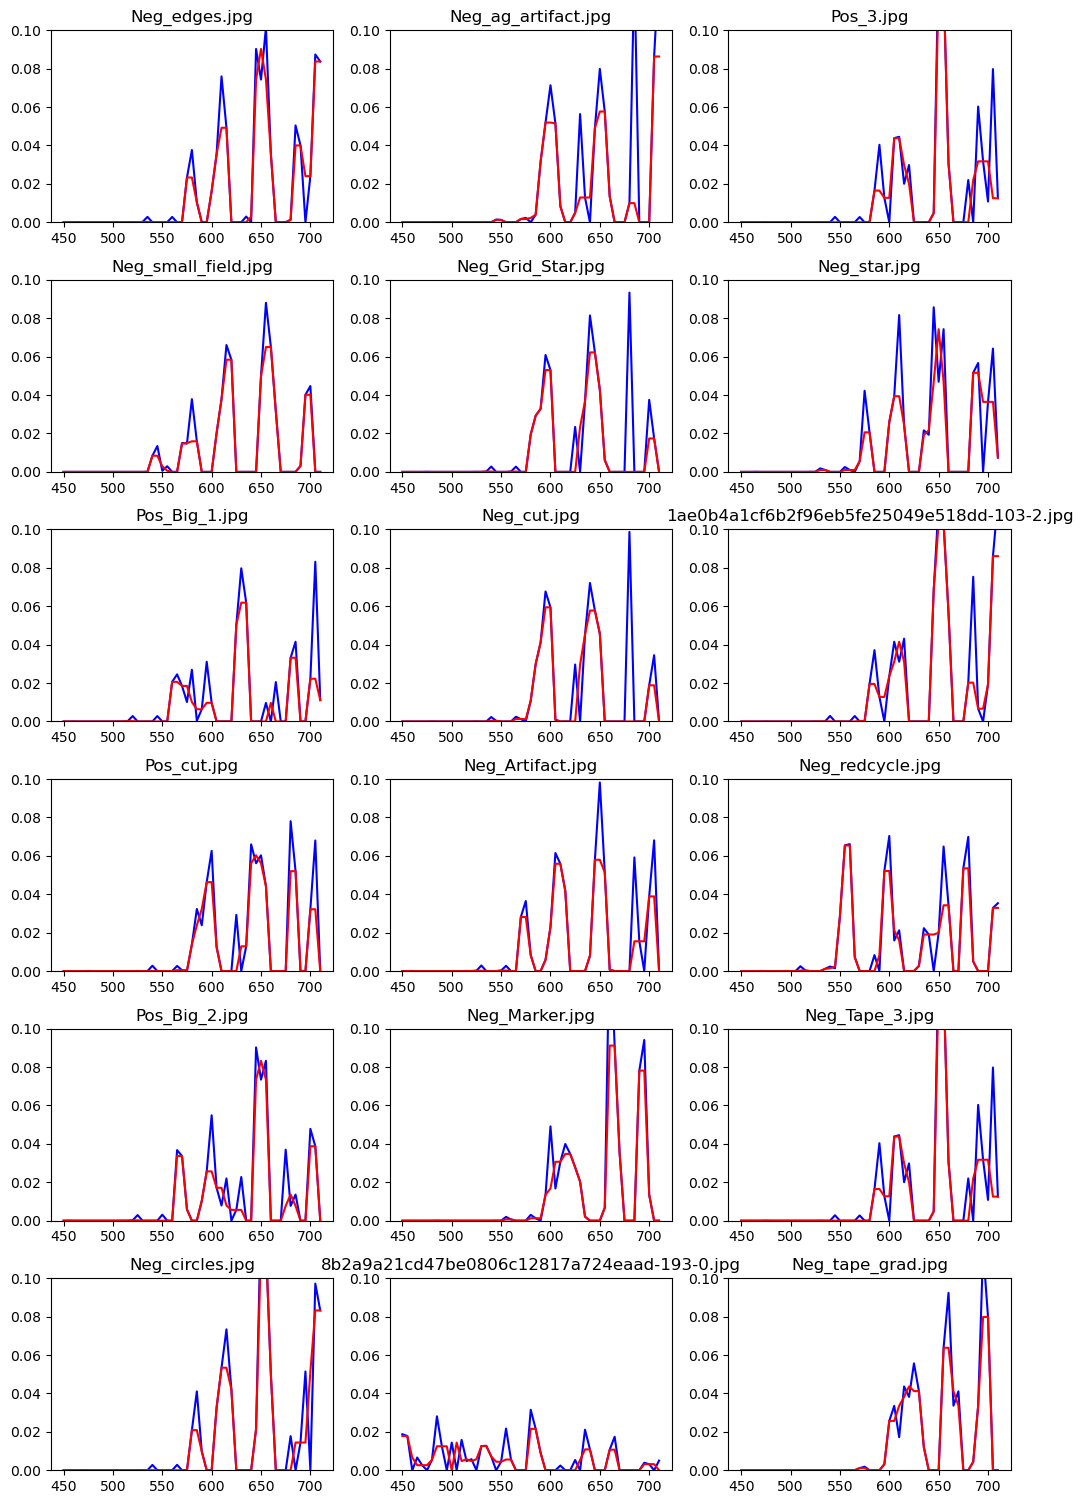

In [56]:
num_col = 3
num_row = 6
xs = np.arange(min_R_search, max_R_search-5, 5)
fig, axs = plt.subplots(nrows=num_row, ncols=num_col, figsize=(12,24))

for i, j in [(i,j) for i in np.arange(num_col) for j in np.arange(num_row)]:
    idx = num_col*j+i
    if idx < len(images):
        der = ders[idx]
        der[der<0]=0
        axs[j,i].plot(xs, der, color='b')
        axs[j,i].plot(xs, signal.medfilt(der, 3), color='r')
        axs[j,i].set_title(file_names[idx])
        axs[j,i].set_ylim(0, 0.1)
        #axs[j,i].yaxis.set_tick_params(labelleft=False)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.7,
                    wspace=0.2,
                    hspace=0.3)
plt.show()

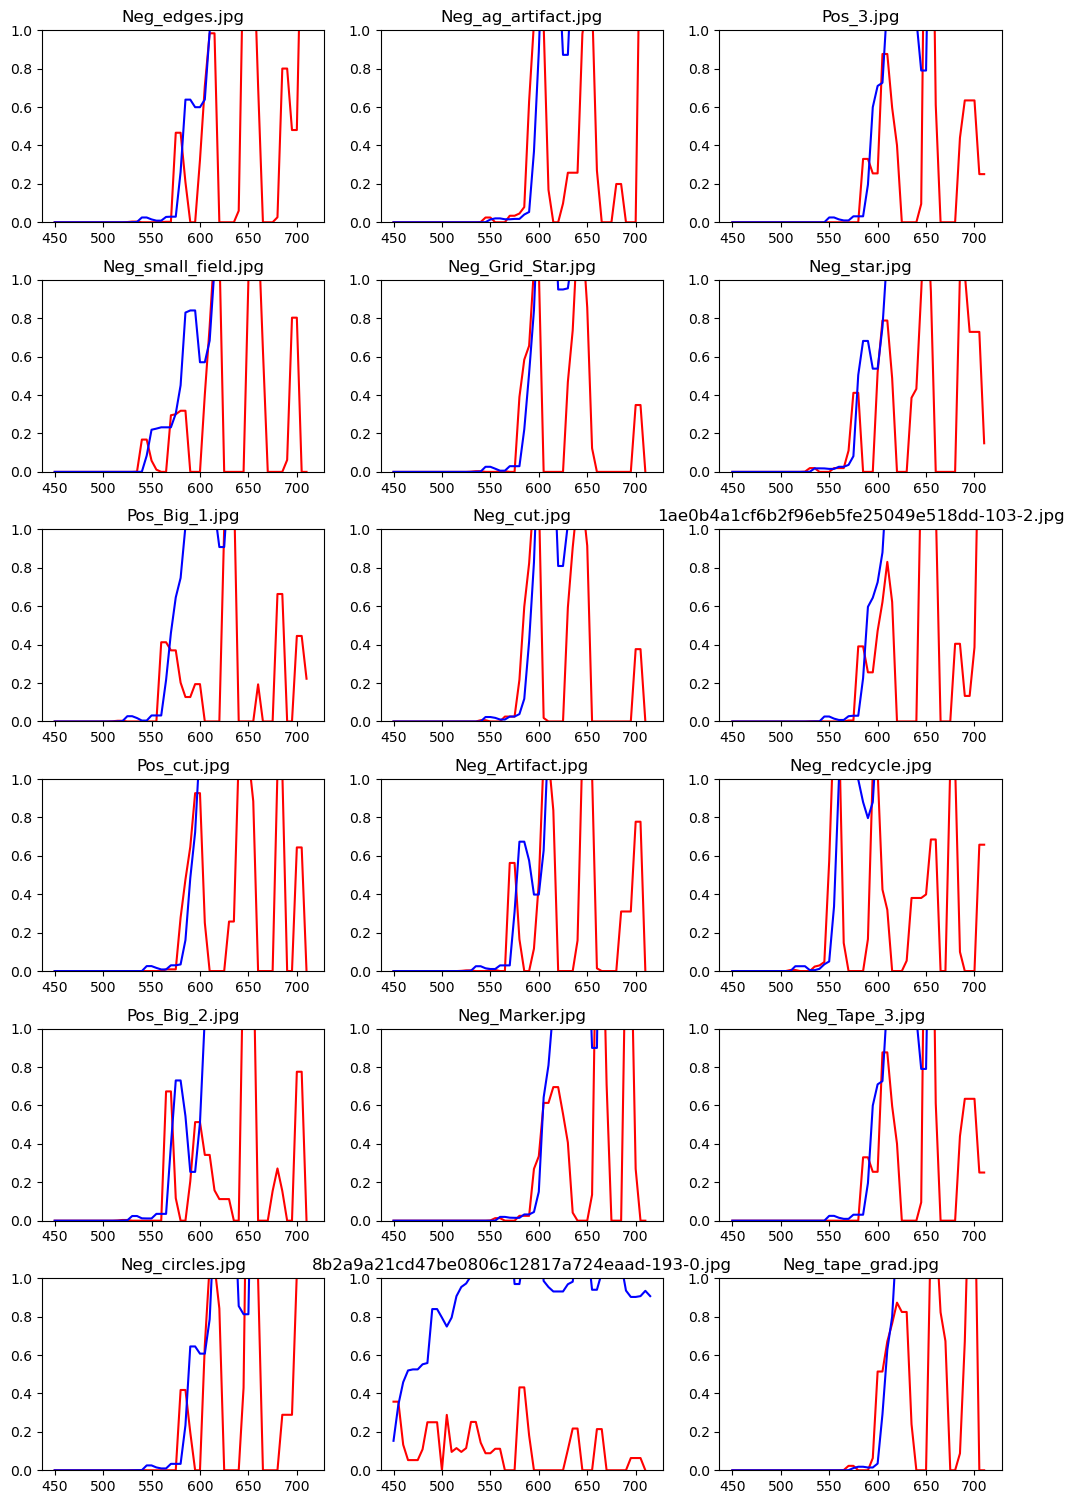

In [58]:
num_col = 3
num_row = 6
xs_int = np.arange(min_R_search, max_R_search, 5)
xs_der = np.arange(min_R_search, max_R_search-5, 5)
fig, axs = plt.subplots(nrows=num_row, ncols=num_col, figsize=(12,24))

for i, j in [(i,j) for i in np.arange(num_col) for j in np.arange(num_row)]:
    idx = num_col*j+i
    if idx < len(images):

        der = ders[idx]
        der[der<0]=0
        axs[j,i].plot(xs_der, signal.medfilt(der, 3)/0.05, color='r')

        intens= ints[idx]
        axs[j,i].plot(xs_int, signal.medfilt(intens, 3)/0.1, color='b')
        axs[j,i].set_title(file_names[idx])
        axs[j,i].set_ylim(0, 1)
        #axs[j,i].yaxis.set_tick_params(labelleft=False)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.7,
                    wspace=0.2,
                    hspace=0.3)
plt.show()

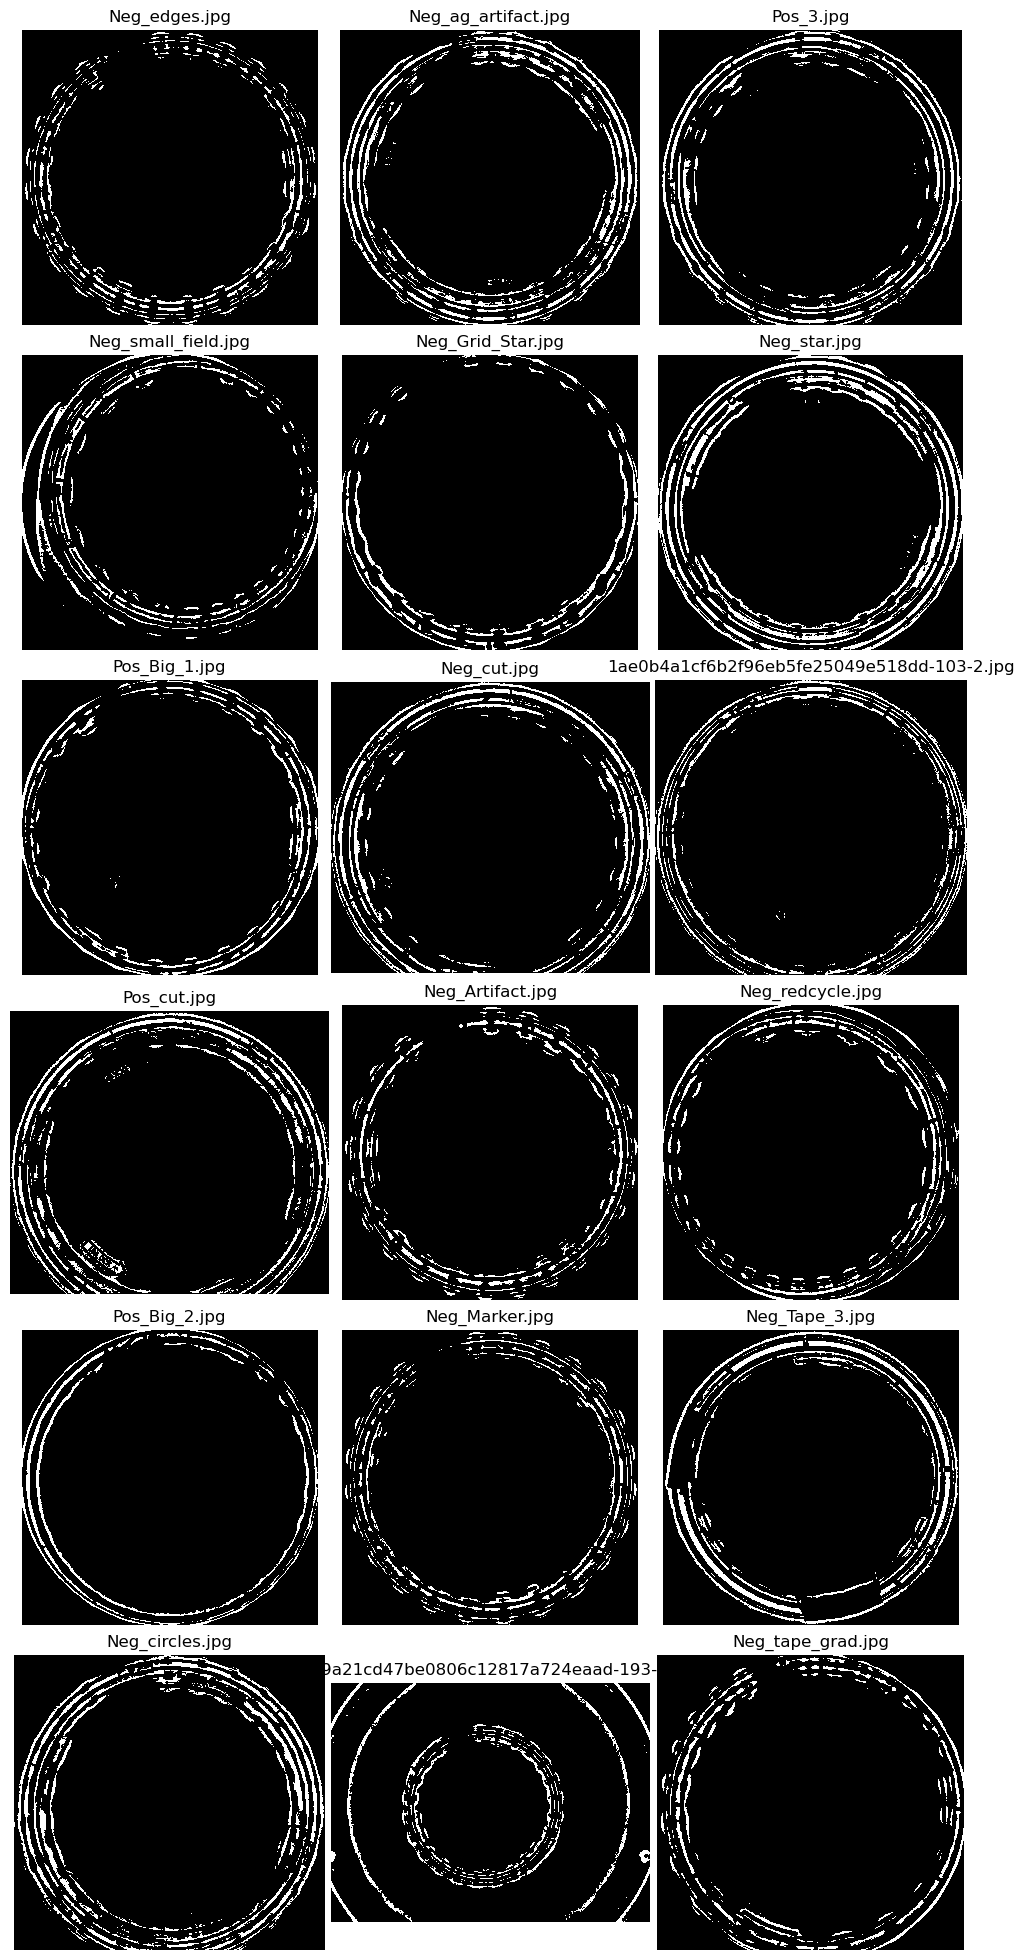

In [54]:
num_col = 3
num_row = 6
fig, axs = plt.subplots(nrows=num_row, ncols=num_col, figsize=(12,24))

for i, j in [(i,j) for i in np.arange(num_col) for j in np.arange(num_row)]:
    idx = num_col*j+i
    if idx < len(threshed):
        img = images[idx]
        img_gr = cv2.adaptiveThreshold(img[:,:,0],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,81,15)
        img_gr = cv2.bitwise_not(img_gr)

        kernel = np.ones((2, 2), np.uint8)
        #dilated = cv2.dilate(img_gr , kernel, iterations = 10)
        eroded = cv2.erode(img_gr , kernel, iterations = 3)

        axs[j,i].imshow(eroded, cmap='Greys_r', interpolation='nearest')
        axs[j,i].set_title(file_names[idx])
        axs[j,i].axis('off')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.005, hspace=0.1)
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

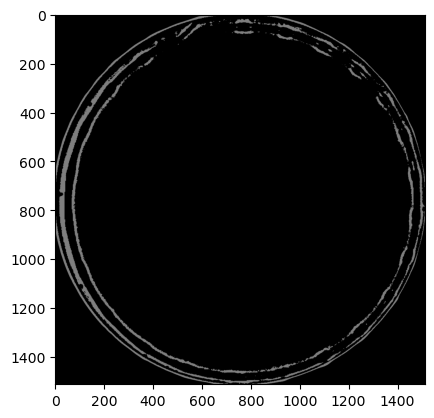

In [47]:
img_gr = cv2.adaptiveThreshold(img[:,:,0],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,41,12)
img_gr = cv2.bitwise_not(img_gr)
img_color = cv2.cvtColor(img_gr, cv2.COLOR_GRAY2BGR)//2

# draw the worst circle
cv2.circle(im_w_circ  , worst_center,4,(0,0,255),10)
cv2.circle(im_w_circ ,worst_center, worst_circ[2],(0,0,255),10)

# draw the cbest circle
cv2.circle(im_w_circ , best_center , 4,(0,0,255),10)
cv2.circle(im_w_circ , best_center , best_circ[2],(255,0,0),10)

plt.imshow(img_color)
plt.show

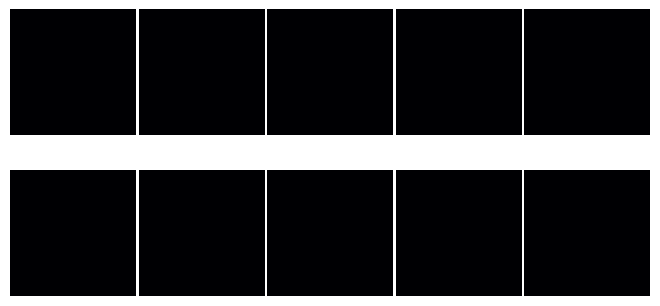

In [48]:
# Make a circular band mask
from matplotlib import colormaps
img_gr = cv2.adaptiveThreshold(img[:,:,0],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,41,12)
img_gr = cv2.bitwise_not(img_gr)
radius = 200
band_width = 40

h = img_gr.shape[0] # Image height
w = img_gr.shape[1] # Image width
Y, X = np.ogrid[:h, :w]

num_col = 5
num_row = 2
fig, axs = plt.subplots(nrows=num_row, ncols=num_col, figsize=(8,8))
center = worst_center
for i, j in [(i,j) for i in np.arange(num_col) for j in np.arange(num_row//2)]:
    idx = num_col*j+i
    in_radius_sq = (radius +(i * band_width)) **2
    out_radius_sq = (radius+((i+1)* band_width))**2
    dist_from_center_sq = (Y - center[1])**2 + (X-center[0])**2
    mask = (dist_from_center_sq >= in_radius_sq ) & (dist_from_center_sq <= out_radius_sq)
    img = img_gr.copy()
    img[~mask] = 0
    axs[j,i].imshow(img, cmap = colormaps['magma'])
    axs[j,i].axis('off')

center = best_center
for i, j in [(i,j) for i in np.arange(num_col) for j in np.arange(num_row//2, num_row )]:
    in_radius_sq = (radius +(i * band_width)) **2
    out_radius_sq = (radius+((i +1)* band_width))**2
    dist_from_center_sq = (Y - center[1])**2 + (X-center[0])**2
    mask = (dist_from_center_sq >= in_radius_sq ) & (dist_from_center_sq <= out_radius_sq)
    img = img_gr.copy()
    img[~mask] = 0
    axs[j,i].imshow(img, cmap = colormaps['magma'])
    axs[j,i].axis('off')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.5, wspace=0.02, hspace=0.01)
plt.show()

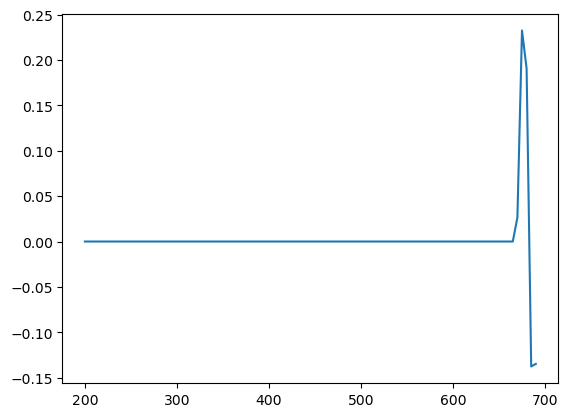

In [49]:
Der_bad = Deriv(image= img_gr, center = worst_center,  min_radius = 200, max_radius = 700, step = 5)

plt.show()

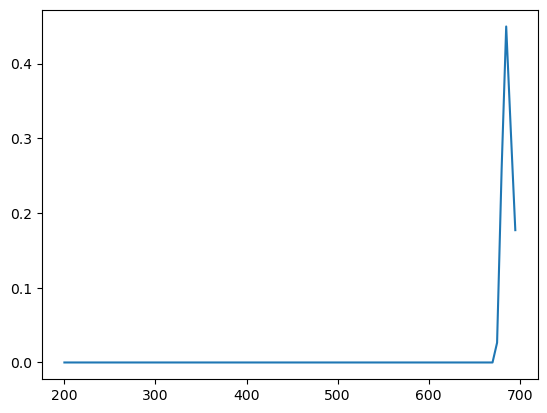

In [50]:
Intensity_f_R = [   Intensity(img_gr, best_center, i, 5)    for i in range(200, 700, 5) ]
xs = np.arange(200, 700, 5)
plt.plot(xs, Intensity_f_R  )
plt.show()

In [ ]:
# Draw histograms
num_col = 2
num_row = 2
fig, axs = plt.subplots(nrows=num_row, ncols=num_col, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(num_col) for j in np.arange(num_row)]:
    idx = num_col*j+i
    if idx < len(images):
        img = images[idx]
        # split the image into blue, green and red channels
        channels = cv2.split(img)
        colors = ("b", "g", "r")
        # loop over the image channels
        for (channel, color) in zip(channels, colors):
            # compute the histogram for the current channel and plot it
            hist = cv2.calcHist(images = [channel], channels=[0], mask = None, histSize=[256], ranges = [3, 256])
            axs[j,i].plot(hist, color=color)
            axs[j,i].yaxis.set_tick_params(labelleft=False)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.6)
plt.show()

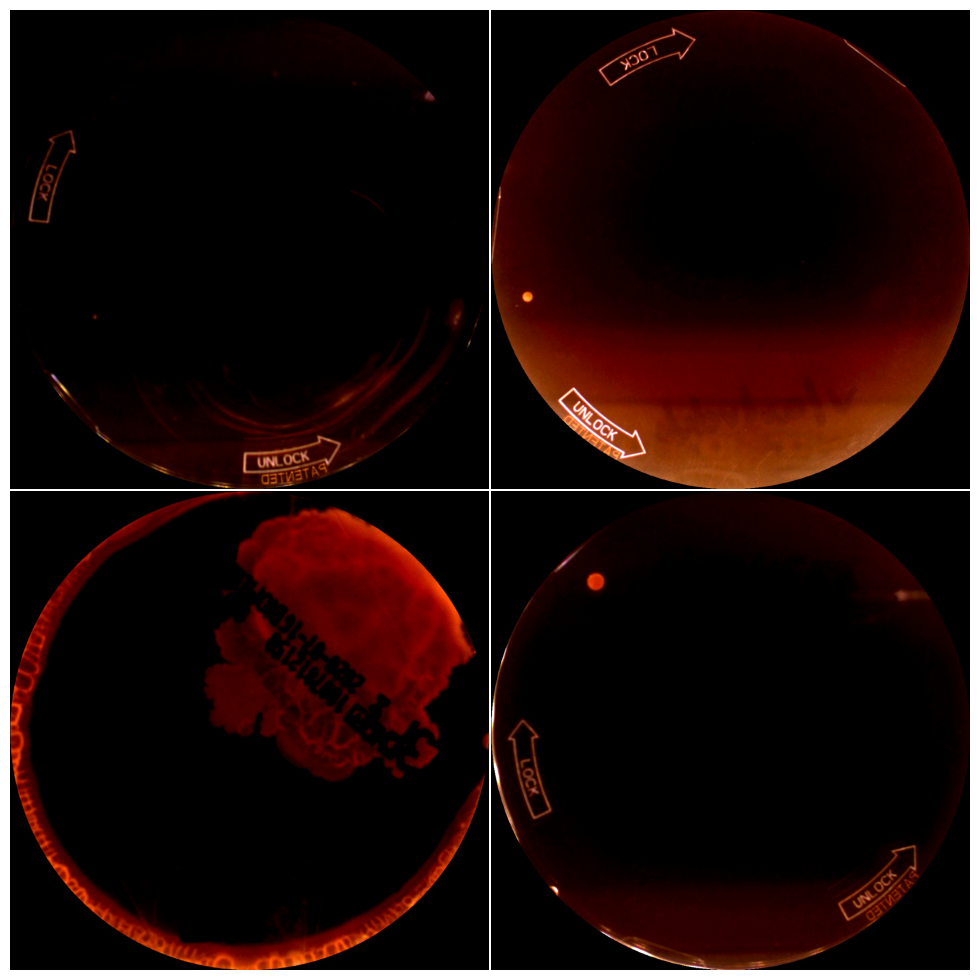

In [73]:
#get a list of files in the folder with pics
folder_path = os.path.abspath('.')+'/Presentation/final'
file_names = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
raw_images = []
for file in file_names:
    image = cv2.imread(folder_path+'/'+file)
    #image = ScaleImage(image)
    raw_images.append(image)
num_col = 2
num_row = 2
fig, axs = plt.subplots(nrows=num_row, ncols=num_col, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(num_col) for j in np.arange(num_row)]:
    idx = num_col*j+i
    if idx < len(raw_images):
        img = raw_images[idx]
        axs[j,i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[j,i].axis('off')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.005, hspace=0.005)
plt.show()

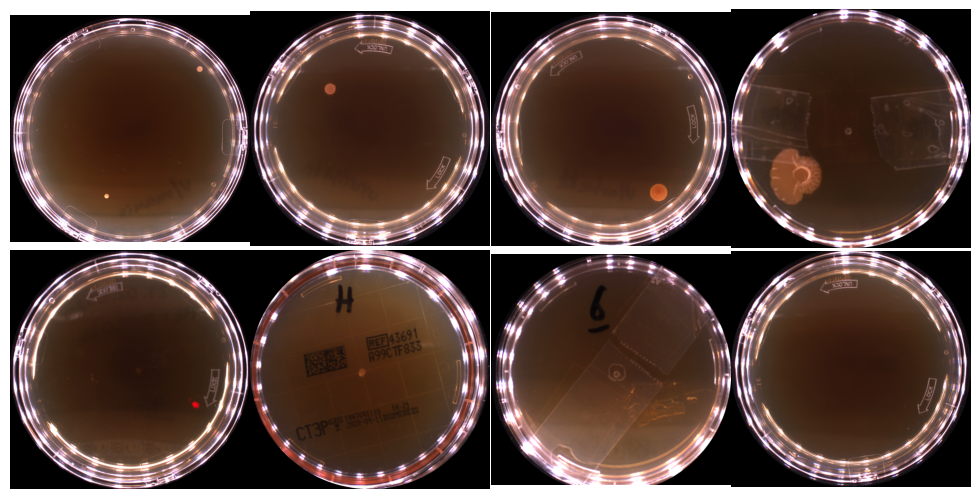

In [79]:
#get a list of files in the folder with pics
folder_path = os.path.abspath('.')+'/Presentation/Sample'
file_names = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
raw_images = []
for file in file_names:
    image = cv2.imread(folder_path+'/'+file)
    #image = ScaleImage(image)
    raw_images.append(image)
num_col = 4
num_row = 2
fig, axs = plt.subplots(nrows=num_row, ncols=num_col, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(num_col) for j in np.arange(num_row)]:
    idx = num_col*j+i
    if idx < len(raw_images):
        img = raw_images[idx]
        axs[j,i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[j,i].axis('off')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.5, wspace=0.005, hspace=0.005)
plt.show()